In [1]:
import numpy as np
import scipy
import random
import pandas as pd
from collections import Counter
import os
from sklearn.metrics import pairwise_distances
import copy
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Data Preprocessing

In [2]:
data = pd.read_csv("/content/kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
data.drop(['id'], axis='columns', inplace=True)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


The following code shows that there's no "NaN" in the original dataset.

In [4]:
print(data.count())
# data.dropna()
# data.count()
data.isnull().values.any()

date             21613
price            21613
bedrooms         21613
bathrooms        21613
sqft_living      21613
sqft_lot         21613
floors           21613
waterfront       21613
view             21613
condition        21613
grade            21613
sqft_above       21613
sqft_basement    21613
yr_built         21613
yr_renovated     21613
zipcode          21613
lat              21613
long             21613
sqft_living15    21613
sqft_lot15       21613
dtype: int64


False

Determine which model to be used for prediction of each feature.

In [5]:
# change yr built/ yr renovated to regression
# add renovated as a binary feature

models = {'price':"Regression", 'bedrooms':"Classification", 'bathrooms':"Classification", 'sqft_living':"Regression", 'sqft_lot':"Regression", 
          'floors':"Classification", 'waterfront':"Classification", 'view':"Classification", 'condition':"Classification", 
          'grade':"Classification", 'sqft_above':"Regression", 'sqft_basement':"Regression", 'yr_built':"Regression", 'yr_renovated':"Regression", 
          'zipcode':"Classification", 'lat':"Regression", 'long':"Regression", 'sqft_living15':"Regression", 'sqft_lot15':"Regression", 
          'year':"Classification", 'month':"Classification", 'day':"Classification",'renovated':"Classification"}

# Create data set with entries being removed

First, we parse date column into three columns: year, month, and day, and drop the original date column.

In [6]:
data = pd.read_csv("/content/kc_house_data.csv")
data.drop(['id'], axis='columns', inplace=True)
data['date'] = data['date'].astype('datetime64[ns]')
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data = data.drop(columns=['date'])
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


1. We use label encoder for the encoding of categorical data.

2. Transform data in yr_rnovated and yr_built such that it become the number of years that have passed since 1900.

In [8]:
le_ = LabelEncoder()
for key in models:
    if key == 'yr_renovated':
        data['renovated'] = (data[key] !=0)*1
        data[key] = (data[key] - 1900) *(data[key] !=0)*1
    if key == 'yr_built':
        data[key] = (data[key] - 1900)

for key in models:
    if models[key] == "Classification":
        if key not in ['yr_renovated','yr_built']:
          # print(key)
          # print('before transform ',data[key].unique())
          data[key] = le_.fit_transform(data[key])
          # print('after transform ',data[key].unique())

        # if key =='zipcode':
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,renovated
0,221900.0,3,3,1180,5650,0,0,0,2,5,1180,0,55,0,66,47.5112,-122.257,1340,5650,0,9,12,0
1,538000.0,3,8,2570,7242,2,0,0,2,5,2170,400,51,91,55,47.7210,-122.319,1690,7639,0,11,8,1
2,180000.0,2,3,770,10000,0,0,0,2,4,770,0,33,0,16,47.7379,-122.233,2720,8062,1,1,24,0
3,604000.0,4,11,1960,5000,0,0,0,4,5,1050,910,65,0,58,47.5208,-122.393,1360,5000,0,11,8,0
4,510000.0,3,7,1680,8080,0,0,0,2,6,1680,0,87,0,37,47.6168,-122.045,1800,7503,1,1,17,0


Shuffle the data

In [9]:
np.random.seed(123)
data = data.sample(frac = 1)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,renovated
5506,532500.0,4,9,2490,8750,2,0,0,2,6,2040,450,76,0,7,47.5931,-122.116,2120,10240,0,7,5,0
9279,410000.0,2,3,1480,4080,0,0,0,2,5,1050,430,49,0,51,47.6842,-122.393,1310,4080,0,7,17,0
16034,782500.0,3,9,3750,7821,2,0,0,2,7,3750,0,101,0,37,47.6325,-122.064,3210,8405,1,3,23,0
6608,995000.0,4,12,3530,20012,2,0,0,2,9,3530,0,86,0,28,47.7193,-122.127,3850,20707,1,3,21,0
20359,279000.0,4,9,2009,4800,2,0,0,2,6,2009,0,112,0,40,47.2586,-122.200,1798,4800,0,11,8,0


In [10]:
data_all = data.values
print(data_all.shape)

(21613, 23)


Generate the data set and we woule likeit  to be consistent in both methods.

In [78]:
p1 = 0.6
p2 = 0.8
train_data = data_all[:int(p1*len(data_all)),:]
vali_data = data_all[int(p1*len(data_all)):int(p2*len(data_all)),:]
test_data = data_all[int(p2*len(data_all)):,:]
print('train_data_shape: ',train_data.shape)
print('vali_data_shape: ',vali_data.shape)
print('test_data_shape: ',test_data.shape)
print(vali_data)

train_data_shape:  (12967, 23)
vali_data_shape:  (4323, 23)
test_data_shape:  (4323, 23)
[[3.5000e+05 3.0000e+00 1.0000e+01 ... 1.0000e+00 2.3000e+01 0.0000e+00]
 [3.0995e+05 4.0000e+00 1.0000e+01 ... 4.0000e+00 4.0000e+00 0.0000e+00]
 [3.3990e+05 4.0000e+00 9.0000e+00 ... 6.0000e+00 1.0000e+01 0.0000e+00]
 ...
 [2.5750e+05 3.0000e+00 7.0000e+00 ... 8.0000e+00 2.4000e+01 0.0000e+00]
 [3.3595e+05 2.0000e+00 5.0000e+00 ... 6.0000e+00 6.0000e+00 0.0000e+00]
 [2.8420e+05 3.0000e+00 9.0000e+00 ... 3.0000e+00 2.3000e+01 0.0000e+00]]


Convert the train data back to data frame in order to calculate the correlation


In [12]:
train_df = pd.DataFrame(train_data,columns=data.columns)
train_df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,renovated
price,1.000000,0.311320,0.530264,0.704079,0.088778,0.250457,0.268825,0.405521,0.026768,0.662403,0.605002,0.331090,0.056306,0.150757,-0.049980,0.308075,0.020882,0.581588,0.080400,0.001408,-0.009888,-0.015403,0.145577
bedrooms,0.311320,1.000000,0.533851,0.592759,0.025084,0.185901,-0.021975,0.079171,0.017871,0.370077,0.492020,0.311146,0.161514,0.032994,-0.165966,-0.008827,0.135587,0.405476,0.017978,-0.008788,0.001926,-0.017124,0.026759
bathrooms,0.530264,0.533851,1.000000,0.758665,0.075032,0.500335,0.060693,0.186177,-0.133308,0.668268,0.684458,0.295880,0.506481,0.067385,-0.198798,0.024468,0.214835,0.568153,0.068273,-0.023941,0.009572,-0.013257,0.057181
sqft_living,0.704079,0.592759,0.758665,1.000000,0.164918,0.349655,0.096465,0.281964,-0.065885,0.764688,0.876815,0.437453,0.316985,0.071849,-0.195248,0.057055,0.240548,0.758310,0.173245,-0.028427,0.015732,-0.010553,0.067298
sqft_lot,0.088778,0.025084,0.075032,0.164918,1.000000,-0.006832,0.021056,0.063082,-0.010756,0.110054,0.176394,0.012688,0.053749,0.009443,-0.122317,-0.081440,0.227869,0.146809,0.691925,-0.000653,0.004926,0.004035,0.010751
floors,0.250457,0.185901,0.500335,0.349655,-0.006832,1.000000,0.025473,0.024830,-0.273298,0.454575,0.520700,-0.247484,0.492346,0.007152,-0.044276,0.048820,0.126183,0.273148,-0.012738,-0.028922,0.021935,-0.000858,0.004115
waterfront,0.268825,-0.021975,0.060693,0.096465,0.021056,0.025473,1.000000,0.421654,0.017753,0.084961,0.069016,0.071309,-0.027372,0.106945,0.033194,-0.015511,-0.046769,0.079922,0.031272,-0.001092,0.000729,0.016185,0.116026
view,0.405521,0.079171,0.186177,0.281964,0.063082,0.024830,0.421654,1.000000,0.043755,0.255810,0.165504,0.276190,-0.053487,0.121579,0.078173,0.012283,-0.085728,0.279786,0.067148,0.016389,-0.016569,0.009336,0.127629
condition,0.026768,0.017871,-0.133308,-0.065885,-0.010756,-0.273298,0.017753,0.043755,1.000000,-0.152706,-0.167463,0.176327,-0.367719,-0.071582,-0.007070,-0.019521,-0.105217,-0.100371,-0.007819,-0.047470,0.018932,-0.011216,-0.063622
grade,0.662403,0.370077,0.668268,0.764688,0.110054,0.454575,0.084961,0.255810,-0.152706,1.000000,0.756565,0.173537,0.444321,0.030700,-0.171341,0.120893,0.193854,0.712554,0.116665,-0.027580,0.007131,-0.016830,0.022127


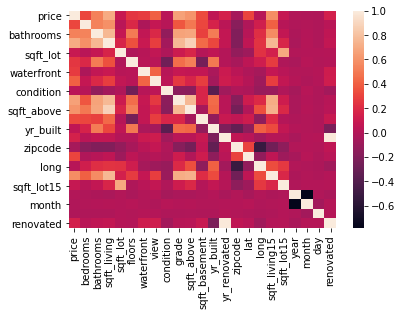

In [13]:
import seaborn as sns
sns.heatmap(train_df.corr())
# The date information may not be useful

In [14]:
def random_remove(data1,prob):
    remove_mask = np.random.uniform(0,1,size = data1.shape)
    remove_mask = (remove_mask > prob)*1
    rm_idx = np.nonzero(remove_mask)
    data1[rm_idx] = np.nan
    return data1, remove_mask

Keep the data based on the probability 0.7. In other words, there is a probability of 0.3 that the data will be removed.

Note: only run once! something goes wrong in colab! repeat this will 

In [15]:
prob = 0.7
vali_data_0 = copy.deepcopy(vali_data)
test_data_0 = copy.deepcopy(test_data)
vali_data_rm,vali_mask = random_remove(vali_data_0,prob)
test_data_rm,test_mask = random_remove(test_data_0,prob)
print(vali_data_rm)
print(test_data_rm)

[[       nan        nan 1.0000e+01 ...        nan        nan 0.0000e+00]
 [3.0995e+05 4.0000e+00 1.0000e+01 ... 4.0000e+00 4.0000e+00 0.0000e+00]
 [3.3990e+05 4.0000e+00 9.0000e+00 ... 6.0000e+00 1.0000e+01 0.0000e+00]
 ...
 [       nan 3.0000e+00        nan ... 8.0000e+00 2.4000e+01 0.0000e+00]
 [3.3595e+05 2.0000e+00 5.0000e+00 ...        nan        nan 0.0000e+00]
 [2.8420e+05 3.0000e+00        nan ...        nan 2.3000e+01 0.0000e+00]]
[[8.12e+05 3.00e+00 1.20e+01 ...      nan 1.90e+01 0.00e+00]
 [6.75e+05 4.00e+00      nan ... 7.00e+00 0.00e+00 0.00e+00]
 [     nan 3.00e+00      nan ...      nan 2.00e+00 0.00e+00]
 ...
 [5.15e+05 2.00e+00 3.00e+00 ...      nan 5.00e+00      nan]
 [     nan 3.00e+00      nan ... 6.00e+00 3.00e+01 0.00e+00]
 [3.20e+05      nan 9.00e+00 ...      nan 5.00e+00      nan]]


In [16]:
print(np.sum(np.isnan(vali_data_rm)))
print(np.sum(np.isnan(test_data_rm)))

29907
30123


In [17]:
X= np.append(train_data,vali_data_rm,axis = 0)
X = np.append(X,test_data_rm,axis = 0)
print(X.shape)
print(X)
X_0= np.append(train_data,vali_data,axis = 0)
X_0 = np.append(X_0,test_data,axis = 0)
print(X_0.shape)
print(X_0)

# use this data instead
# control the probability of the missing data
# notation:
# X: data including missing values for method 1
# X_0: the ground truth for method 1
# train_data: dAE gt
# vali_data: dAE gt
# test_data: dAE gt
# vali_data_rm: dAE mv
# test_data_rmL dAE mv

(21613, 23)
[[5.325e+05 4.000e+00 9.000e+00 ... 7.000e+00 5.000e+00 0.000e+00]
 [4.100e+05 2.000e+00 3.000e+00 ... 7.000e+00 1.700e+01 0.000e+00]
 [7.825e+05 3.000e+00 9.000e+00 ... 3.000e+00 2.300e+01 0.000e+00]
 ...
 [5.150e+05 2.000e+00 3.000e+00 ...       nan 5.000e+00       nan]
 [      nan 3.000e+00       nan ... 6.000e+00 3.000e+01 0.000e+00]
 [3.200e+05       nan 9.000e+00 ...       nan 5.000e+00       nan]]
(21613, 23)
[[5.325e+05 4.000e+00 9.000e+00 ... 7.000e+00 5.000e+00 0.000e+00]
 [4.100e+05 2.000e+00 3.000e+00 ... 7.000e+00 1.700e+01 0.000e+00]
 [7.825e+05 3.000e+00 9.000e+00 ... 3.000e+00 2.300e+01 0.000e+00]
 ...
 [5.150e+05 2.000e+00 3.000e+00 ... 1.000e+01 5.000e+00 0.000e+00]
 [6.400e+05 3.000e+00 1.100e+01 ... 6.000e+00 3.000e+01 0.000e+00]
 [3.200e+05 4.000e+00 9.000e+00 ... 9.000e+00 5.000e+00 0.000e+00]]


For models beside Denoising Autoencoder, all the data points are used throughout the data imputaion process.

Then, to create data set with missing values, we randomly remove entries from the data set in the following way:

1. Randomly selected rows from which we want to remove some items.

2. For each selected row, randomly select items to be removed.

In [ ]:
num_rows = data.count()[0]
num_cols = len(data.columns)

row_to_rmv = np.random.randint(2, size = num_rows)
for i, j in enumerate(row_to_rmv.tolist()):
    if j == 1:
        # i-th row is selected
        col_to_rmv = np.random.randint(2, size = num_cols)
        for k, l in enumerate(col_to_rmv.tolist()):
            if l == 1:
                # Remove k-th entry of the i-th row
                data_rmv.iloc[i,k] = None

For Denoising Autoencoder:

The data set is divided into training (60%), validation (20%), and testing (20%). All the data in the training set are retained while those in the validation and testing sets contain missing values.

In [ ]:
num_train = int(num_rows*0.6)
num_test = int(num_rows*0.2)
num_val = num_rows - num_train - num_test
row_to_rmv = np.concatenate((np.zeros(num_train), np.ones(num_val), np.full(num_test, 2)), axis=None)
row_to_rmv = np.random.permutation(row_to_rmv)

print(row_to_rmv)
data_VAE = data.copy()
# for i, j in enumerate(row_to_rmv.tolist()):
#     if j >= 1:
#         # i-th row is selected
#         col_to_rmv = np.random.randint(2, size = num_cols)
#         for k, l in enumerate(col_to_rmv.tolist()):
#             if l >= 1:
#                 # Remove k-th entry of the i-th row
#                 data_VAE.iloc[i,k] = None

[0. 1. 1. ... 0. 1. 0.]


In [ ]:
# le_ = LabelEncoder()
# le_rmv = LabelEncoder()
# le_VAE = LabelEncoder()
# for key in models:
#     if models[key] == "Classification":
#         data[key] = le_.fit_transform(data[key])
#         data_rmv[key] = le_rmv.fit_transform(data_rmv[key])
#         data_VAE[key] = le_VAE.fit_transform(data_VAE[key])
        # data[key] = data[key].astype('category').cat.codes
        # data[key] = data[key].replace({-1: np.nan})
        # data_rmv[key] = int(data_rmv[key].astype('category').cat.codes)
        # data_rmv[key] = data_rmv[key].replace({-1: np.nan})
        # data_VAE[key] = data_VAE[key].astype('category').cat.codes
        # data_VAE[key] = data_VAE[key].replace({-1: np.nan})

# Note: the data has been changed

# X = data_rmv.copy()
# X_0 = data.copy()
# X_train_VAE = data_VAE.iloc[np.nonzero(row_to_rmv == 0.0)[0], 0:]
# X_val_VAE = data_VAE.iloc[np.nonzero(row_to_rmv == 1.0)[0], 0:]
# X_test_VAE = data_VAE.iloc[np.nonzero(row_to_rmv == 2.0)[0], 0:]
# X_val_VAE.head()

# Supervised Learning

# Classification

1.Mode Classifier

2.Decision Tree Classifier

3.Logistic Regression Classifier

4.K-Nearest Neighbor Classifier

In [ ]:
class Mode():
    def predict(self, X):
        counts = Counter(X)
        return counts.most_common(1)[0][0]
        
    def get_err(self, y, y_pred):
        y = np.asarray(y)
        y_pred = np.asarray(y_pred)
        return np.mean((y_pred == y))

In [ ]:
class Node:
    def __init__(self, pred_cls):
        self.pred_cls = pred_cls
        self.feat_idx = 0
        self.thres = 0
        self.lchild = None
        self.rchild = None
        
class DecisionTreeClf():
    def __init__(self, max_depth=10):
        self.max_depth = max_depth

    def split(self, X, y):
        m = len(y)
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.num_classes)]

        best_gini = 0
        for n in num_parent:
            best_gini = best_gini + (n / m) ** 2 
        best_gini = 1.0 - best_gini
        best_index, best_thres = None, None

        for idx in range(self.num_feats):
            # Sort
            thres, clses = zip(*sorted(zip(X[:, idx], y)))
            num_l = [0] * self.num_classes
            num_r = num_parent.copy()
            for i in range(1, m):
                c = int(clses[i - 1])
                print(c)
                print(clses[i - 1])
                num_l[c] += 1
                num_r[c] -= 1
                gini_l = 0
                for x in range(self.num_classes):
                    gini_l += (num_l[x] / i) ** 2 
                gini_l = 1.0 - gini_l
                gini_r = 0
                for x in range(self.num_classes):
                    gini_r += (num_r[x] / (m - i)) ** 2 
                gini_r = 1.0 - gini_r
                gini = (i * gini_l + (m - i) * gini_r) / m
                if thres[i] == thres[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_index = idx
                    best_thres = (thres[i] + thres[i - 1]) / 2  # midpoint
        return best_index, best_thres     

    def fit(self, X, y):
        self.num_feats = X.shape[1]
        self.num_classes = len(set(y))
        self.tree = self.Treeify(X,y)

    def Treeify(self, X, y, depth=0):
        cls_cnt = [np.sum(y == i) for i in range(self.num_classes)]
        pred_cls = np.argmax(cls_cnt)
        node = Node(pred_cls=pred_cls)
        if depth < self.max_depth:
            idx, thres = self.split(X, y)
            if idx is not None:
                idx_l = X[:, idx] < thres
                X_left = X[idx_l]
                y_left = y[idx_l]
                X_right = X[~idx_l]
                y_right = y[~idx_l]
                node.feat_idx = idx
                node.thres = thres
                node.lchild = self.Treeify(X_left, y_left, depth + 1)
                node.rchild = self.Treeify(X_right, y_right, depth + 1)
        return node

    def predict(self, X):
        return [self._predict(x) for x in X]

    def _predict(self, X):
        node = self.tree
        while node.lchild:
            if X[node.feat_idx] < node.thres:
                node = node.lchild
            else:
                node = node.rchild
        return node.pred_cls
        
# if __name__ == "__main__":
#     import sys
#     from sklearn.datasets import load_iris

#     dataset = load_iris()
#     dt = DecisionTreeClf(max_depth=10)
#     dt.train(dataset.data, dataset.target)
#     print(dt.predict([[0, 0, 5, 1.5]]))

In [ ]:
# note
# we use one hot embedding in this classification method
# to generalize it from binary classification to multi-class classification
class LogisticReg:
    def __init__(self,epoch=1000,lr=0.1):
        self.epoch = epoch
        self.lr = lr

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def fit(self,X,y):
        eps = np.finfo(float).eps
        class_num = int(np.max(y)+1)
        print(class_num)
        one_hot_y = np.zeros((len(y),class_num))
        y = np.array(y,dtype=int)
        one_hot_y[np.arange(len(y)),y] = 1
        # print(one_hot_y)

        self.weights = np.random.rand(X.shape[1],class_num)
        self.loss = []
        for i in range(self.epoch):
            y_hat = self.sigmoid(X @ self.weights)
            self.weights = self.weights - self.lr*(X.T @ (y_hat-one_hot_y))#/X.shape[0]
            # print(X.T @ (y_hat-one_hot_y)/X.shape[0])
            self.loss.append(-np.mean(one_hot_y*np.log(self.sigmoid(X @ self.weights)+eps) + (1-one_hot_y)*np.log(1-self.sigmoid(X @ self.weights)+eps)))
        # early stop
            if np.sum(self.lr*(np.abs(X.T @ (y_hat-one_hot_y)))) < 1e-8:
                print('early stop at epoch: ', i)
                break

    def predict(self,X_test,threshold = 0.5):
        y_prob = X_test@self.weights
        y_pred = np.argmax(y_prob,axis=1)
        return y_pred
        
    def get_err(self, y, y_pred):
        return np.mean((y_pred == y))

# x_trn = np.array([[-1,-1], [-1,1], [1,-1], [1,1]])
# y_trn = np.array([0,0,1,1])
# print(x_trn.shape)
# print(y_trn.shape)
# logR = LogisticReg()
# logR.fit(x_trn,y_trn)
# print(logR.predict(x_trn))
# plt.plot(logR.loss)

In [ ]:
class KnnClf:
    def __init__(self,k=5):
        self.k = k

    def fit(self, X, y):
        self.x_train = X
        self.y_train = y

    def predict(self, x_test):
        y_pred = []
        for x_t in x_test:
            distance = np.sqrt(np.sum((self.x_train-x_t)**2,axis=1))
            sort_index = np.argsort(distance)
            select_index = sort_index[0:self.k]
            labels = []
            for each in select_index:
                labels.append(self.y_train[each])
            maxlabel = max(labels,key = labels.count)
            y_pred.append(maxlabel)
        return y_pred
    
    def get_err(self, y, y_pred):
        return np.mean((y_pred == y))

# Regression

In [95]:
class Mean():
    def predict(self, X):
        return np.mean(X)
        
    def get_err(self, y, y_pred):
        return np.mean(np.square(np.asarray(y) - np.asarray(y_pred)))

In [96]:
class LinearReg:
    def __init__(self, Ws = None, Bs = None):
        self.w = Ws
        self.b = Bs

    def predict(self, X):
        return np.dot(X, self.w) + self.b

    def fit(self, X, y):
        X = np.column_stack((np.ones(X.shape[0],'float'), X))
        self.W = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        self.w = self.W[1:]
        self.b = self.W[0]

    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

class linear_reg:
    def __init__(self,n_iter=1000,lr=5e-4):
        self.n_iter = n_iter
        self.lr = lr

    def fit(self,X,y):
        X = np.insert(X,0,1,axis = 1)
        self.mse = []
        _,n_feature = X.shape
        self.w = np.zeros((n_feature,))
        for i in range(self.n_iter):
            error = np.mean((y - np.dot(X,self.w))**2)
            self.mse.append(error)
            grad_w = -(y - X.dot(self.w)).dot(X)
            self.w -= self.lr * grad_w

    def predict(self,X):
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

In [97]:
class RidgeReg:
    def __init__(self, Bs = None, Ws = None, lamb = 0.1):
        self.b = Bs
        self.w = Ws
        self.lamb = lamb

    def fit(self, X, y):
        X = np.column_stack((np.ones(X.shape[0],'float'), X))
        self.W = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)
                                             + self.lamb*np.identity(X.shape[1])), X.T), y)
        self.w = self.W[1:]
        self.b = self.W[0]
    
    def predict(self, X):
        return (np.dot(X, self.w) + self.b)

    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

class ridge_reg:
    def __init__(self,n_iter=1000,lr=5e-4,l2=0.01):
        self.n_iter = n_iter
        self.lr = lr
        self.l2 = l2

    def fit(self,X,y):
        X = np.insert(X,0,1,axis = 1)
        self.mse = []
        _,n_feature = X.shape
        self.w = np.zeros((n_feature,))
        for i in range(self.n_iter):
            error = np.mean((y - X.dot(self.w))**2)
            self.mse.append(error)
            grad_w = -(y - X.dot(self.w)).dot(X) + self.l2*self.w
            self.w -= self.lr * grad_w

    def predict(self,X):
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

In [98]:
class LassoReg:
    def __init__(self, Bs = None, Ws = None, lamb = 0.05, num_iter = 100):
        self.b = Bs
        self.w = Ws
        self.lamb = lamb
        self.num_iter = num_iter
        
    # Soft threshold function used for coordinate descent lasso regression 
    def threshold(self, rho_j, lamb, z_j):
        if rho_j > lamb/2:
            return (rho_j - lamb/2)/z_j
        elif rho_j < (-1)*lamb/2:
            return (rho_j + lamb/2)/z_j 
        else:
            return 0.0
        
    def fit(self, X, y):
        X = np.column_stack((np.ones(X.shape[0],'float'), X))
        self.W = np.zeros((X.shape[1],1),'float')
        # Recall from the 2nd question of HW4 that E[\hat{b}] = b
        # and \hat{b} = y_i - \hat{w}x_i,
        # so the bias b = average of (actual y_i - predicted y_i)
        y_pred_0 = np.dot(X[:, 1:], self.W[1:]).flatten()
        self.b = np.sum(y - y_pred_0)/X.shape[0]
        self.W[0] = self.b
        for i in range(self.num_iter):
            for j in range(1,X.shape[1]):
                tmp_w = self.W.copy()
                tmp_w[j] = 0.0 # Exclude w_j
                y_pred = np.dot(X, tmp_w)
                r = y - y_pred.flatten()
                z_j = np.sum(np.square(X[:, j]))
                rho_j = np.dot(X[:, j], r)
                self.W[j] = self.threshold(rho_j, self.lamb*X.shape[0], z_j)
        self.w = self.W[1:]
    
    def predict(self, X):
        return (np.dot(X, self.w) + self.b).flatten()
     
    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

In [99]:
import numpy as np
class Layer():
    def __init__(self,input_dim,output_dim):

        self.weights = np.random.rand(input_dim,output_dim)/np.sqrt(input_dim)
        self.bias = np.zeros(output_dim)

    def forward(self,input_data):
        self.input = input_data
        # print('layer self input',self.input.shape)
        # print('layer self weights',self.weights.shape)
        # print('test',self.bias.shape)
        self.output = self.input @ self.weights +self.bias
        # print('layer self output',self.output.shape)
        # print('self.bias check',self.bias.shape)
        return self.output
    # error: error from next layer
    # new_error: error that will be backwarded to the previous layer
    def backward(self,error,lr):
        # print('self.bias check',self.bias.shape)
        # print('error check',error.shape)
        grad_weight = self.input.T @ error
        grad_bias = np.mean(error,axis=0)*self.input.shape[0]
        grad_bias = grad_bias.reshape(self.bias.shape)
        assert grad_weight.shape == self.weights.shape
        assert grad_bias.shape == self.bias.shape
        self.weights = self.weights - lr*grad_weight
        self.bias = self.bias - lr * grad_bias
        
        # print('self.bias check',self.bias.shape)
        new_error = error @ self.weights.T
        return new_error

class Activate():
    def __init__(self,f,fp):
        self.f = f
        self.fp = fp
    def forward(self,input_data):
        self.input = input_data
        self.output = self.f(self.input)
        return self.output
    def backward(self,error,lr):
        # print('error check',error.shape)
        # print('input check',self.input.shape)
        # print('output check',self.output.shape)
        new_error = self.fp(self.input) * error
        # print('error check',new_error.shape)
        return new_error

class Network:
    def __init__(self,layers):
        self.layers = layers

    def loss_function(self,lf,lfp):
        self.loss = lf
        self.loss_p = lfp

    def predict(self,input_data):
        y_out = input_data
        for layer in self.layers:
            # print('input_for_each_layer',layer,y_out.shape)
            y_out = layer.forward(y_out)
            # print('output_for_each_layer',layer,y_out.shape)
        return y_out
    # we would like to perform SGD in the training process
    def train(self,X,y,epochs,lr,batch_size = 1):

        for i in range(epochs):
            epoch_error = 0

            for j in range(0,len(y),batch_size):
                s = j
                e = min(j+batch_size,len(y))
                X_batch = X[s:e]
                y_batch = y[s:e]
                y_pred = self.predict(X_batch)
                y_batch = y_batch.reshape(y_pred.shape)
                epoch_error += self.loss(y_batch,y_pred)
                error_batch_p = self.loss_p(y_batch,y_pred)

                for layer in reversed(self.layers):
                    # print('back check',layer)
                    # print(error_batch_p.shape)
                    error_batch_p = layer.backward(error_batch_p,lr)
                # if j % 1000 == 0:
                #     print('batch: {}/{}   loss={}'.format(j,len(X),self.loss(y_batch,y_pred)))
            epoch_error = epoch_error/(len(y)/batch_size)
            self.epoch_error = epoch_error
            # if i % 500 == 0:
            #     print('---------------------------')
            #     print('epoch: {}   loss={}'.format(i,epoch_error))

# loss functions
class loss_function_set():
    # MSE loss function:
    # input: y label and y prediction
    # output: a mse value
    def mse(self,y_true,y_pred):
        # value
        return np.mean((y_true-y_pred)**2)

    def mse_p(self,y_true,y_pred):
        # return -2*(np.sum(y_true-y_pred,axis = 0))/len(y_true)
        # [batch,class]
        return -2*(y_true-y_pred)/len(y_true)

        # return -2*(np.sum(y_true-y_pred,axis=0).reshape(1,y_true.shape[1]))/len(y_true)

#activation functions:
class activation_set():
    def tanh(self,x):
        return np.tanh(x)
    def tanh_p(self,x):
        return 1-np.tanh(x)**2
    def relu(self,x):
        return np.maximum(0,x)
    def relu_p(self,x):
        return x>0


In [100]:
# x_trn = np.array([[-1,-1], [-1,1], [1,-1], [1,1],[-1,-1], [-1,1], [1,-1], [1,1]])
# y_trn = np.array([1,-1,-1,1,1,-1,-1,1])

# act_f = activation_set()
# loss_f =loss_function_set()
# # network
# net = Network(layers = [Layer(2, 4),
#                         Activate(act_f.tanh, act_f.tanh_p),
#                         Layer(4, 1),
#                         Activate(act_f.tanh, act_f.tanh_p)
#                         ])
# # train
# net.loss_function(loss_f.mse, loss_f.mse_p)
# net.train(x_trn, y_trn, epochs=1000, lr=0.1,batch_size = 5)

# # test
# out = net.predict(x_trn)
# print(out)

In [101]:
class KnnReg:
    def __init__(self,k=5):
        self.k = k

    def fit(self, X, y):
        self.x_train = X
        self.y_train = y

    def predict(self, x_test):
        y_pred = []
        for x_t in x_test:
            distance = np.sqrt(np.sum((self.x_train-x_t)**2,axis=1))
            sort_index = np.argsort(distance)
            select_index = sort_index[0:self.k]
            labels = []
            for each in select_index:
                labels.append(self.y_train[each])
            y_pred.append(np.mean(labels))
        return y_pred
    
    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))



In [102]:
class Node_reg():
    def __init__(self, X, y, idx, threshold=3):
        self.X = X 
        self.y = y
        self.idx = idx 
        self.threshold = threshold
        self.num_samples = len(idx)
        self.num_feats = X.shape[1]
        self.val = np.mean(y[idx])
        self.wtd_std = float('inf')
        self.split_data()

    def get_wtd_std(self, L, R):
        y = self.y[self.idx]
        return y[L].std() * L.sum() + y[R].std() * R.sum()
             
    def split_feat(self):
        return self.X.values[self.idx, self.feat_idx]
            
    def leaf(self):
        return self.wtd_std == float('inf')

    def split_data(self):
        for ft_i in range(self.num_feats):
            self.get_split(ft_i)
        if self.leaf:
            return
        X = self.split_feat
        self.lchild = Node_reg(self.X, self.y, self.idx[np.nonzero(X <= self.split)[0]], self.threshold)
        self.rchild = Node_reg(self.X, self.y, self.idx[np.nonzero(X > self.split)[0]], self.threshold)

    def get_split(self, feat_idx):
        X = self.X.values[self.idx, feat_idx]
        for p in range(self.num_samples):
            L = X <= X[p]
            R = X > X[p]
            if R.sum() < self.threshold or L.sum() < self.threshold:
                continue
            tmp_wtd_std = self.get_wtd_std(L, R)
            if tmp_wtd_std < self.wtd_std:
                self.feat_idx = feat_idx
                self.wtd_std = tmp_wtd_std
                self.split = X[p]
      
    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        if self.leaf:
            return self.val
        if x[self.feat_idx] <= self.split:
            node = self.lchild
        else:
            node = self.rchild
        return node._predict(x)  
        
class DecisionTreeReg():
    def fit(self, X, y, threshold=3):
        X = pd.DataFrame(data = X[0:,0:], index = [i for i in range(X.shape[0])], columns=[str(i) for i in range(X.shape[1])])
        y = pd.Series(y)
        self.dt = Node_reg(X, y, np.array(np.arange(len(y))), threshold)
        return self
  
    def predict(self, X):
        X = pd.DataFrame(data = X[0:,0:], index = [i for i in range(X.shape[0])], columns=[str(i) for i in range(X.shape[1])])
        return self.dt.predict(X.values)


# dt_reg = DecisionTreeReg()
# dt_reg.fit(X_train, y_train)
# y_pred = dt_reg.predict(X_test)
# rmse = np.sqrt(np.sum(np.square(y_test - y_pred)))
# rmse

# Unsupervised Learning
Kmeans

Variational Autoencoder

In [ ]:
class KMeans():
    def __init__(self, k = 5, num_iter = 100, seed = 2020):
        self.k = k
        self.num_iter = num_iter
        np.random.seed(seed)

    def initialize(self, X):
        rand_idx = np.random.permutation(X.shape[0])
        rand_idx = rand_idx[:self.k]
        self.centroids = X[rand_idx]

    def get_labels(self, X):
        dists = pairwise_distances(X, self.centroids, metric = 'euclidean')
        labels = np.argmin(dists, axis = 1)
        return labels

    def update(self, X, labels):
        for cluster in range(self.k):
            X_cluster = X[labels == cluster]
            mean = np.mean(X_cluster, axis = 0)
            self.centroids[cluster] = mean

    def fit(self, X):
        self.initialize(X)
        iters = 0
        while iters <= self.num_iter:
            iters += 1
            labels = self.get_labels(X)
            self.update(X, labels)

    def predict(self, X):
        return self.get_labels(X)

# Experiments

Data Preprocessing

Experiments of method 1

In [ ]:
import numpy as np

class imputation:
    def __init__(self,X,X_0):
        self.X = X
        self.X_0 = X_0
    # order_list: contains the ordered feature cols
    # for example [1,3,2,5,4,0] means col 1 has the least missing value, col 0 has the most

    # def normalization(self,X):
    #     return (X-np.mean(X))/np.std(X,axis = 0),np.mean


    def train_test_split(self,X,f_i,order_list):
        f_i = f_i + 1
        select_features = order_list[:f_i]
        X_part = X[:,select_features]
        X_part_0 = self.X_0[:,select_features]
        train_data = X_part[~np.isnan(X_part).any(axis=1),:]
        test_data = X_part[np.isnan(X_part).any(axis=1),:]

        t = len(train_data)
        X_train = train_data[:int(0.8*t),0:f_i-1]
        y_train = train_data[:int(0.8*t),f_i-1]
        X_vali = train_data[int(0.8*t):,0:f_i-1]
        y_vali = train_data[int(0.8*t):,f_i-1]
        X_test = test_data[:, 0:f_i-1]

        # y test should be the real value instead of the nan value
        y_test = X_part_0[np.isnan(X_part).any(axis=1),f_i-1]
        # record the idx of y_test to do the update
        y_test_idx = np.isnan(X_part).any(axis=1)
        return X_train,y_train,X_vali,y_vali,X_test,y_test,y_test_idx

    def sort_features(self):
        mv_mask = np.isnan(self.X)
        mv_count = np.sum(mv_mask*1,axis = 0)
        order_list = np.argsort(mv_count)
        return order_list

    def mse(self,y_true,y_pred):
        return np.sqrt(np.sum((y_true-y_pred)**2))

    def accuracy(self,y_true,y_pred):
        return np.sum(y_pred==y_true)/len(y_true)

    def update(self,y_imp,y_idx_0,y_idx_1):
        self.X[y_idx_0,y_idx_1] = y_imp


    # models: a list of different models
    def fit(self,model_type,reg_models = None,class_models = None):
        order_list = self.sort_features()
        #start with one full filled column
        if model_type[order_list[0]] == 'Regression':
            if np.sum(np.isnan(self.X[:,order_list[0]])) !=0:
                self.X[np.isnan(self.X[:,order_list[0]]),order_list[0]] = np.mean(self.X[~np.isnan(self.X[:,order_list[0]]),order_list[0]])

        if model_type[order_list[0]] == 'Classification':
            if np.sum(np.isnan(self.X[:,order_list[0]])) !=0:
                self.X[np.isnan(self.X[:,order_list[0]]),order_list[0]] = Counter(self.X[~np.isnan(self.X[:,order_list[0]]),order_list[0]]).most_common(1)[0][0]

        for i in range(1,len(order_list)):
            X_train,y_train,X_vali,y_vali,X_test,y_test,y_test_idx = self.train_test_split(self.X,i,order_list)
            print('iter:{} target_feature:{}'.format(i,order_list[i]))
            # model selection:
            # model_type: a pre defined list storing the type of features
            if model_type[order_list[i]] == 'Regression':

                reg_mse_vali = []
                reg_mse_test = []
                y_pred_rec = []
                for model_name in reg_models:
                  # need to change according to different models
                    print("Regression using {}".format(model_name))
                    model = model_name()
                    model.fit(X_train,y_train)
                    y_vali_pred = model.predict(X_vali)
                    reg_mse_vali.append(self.mse(y_vali,y_vali_pred))
                    y_pred = model.predict(X_test)
                    y_pred_rec.append(y_pred)
                    reg_mse_test.append(self.mse(y_test,y_pred))
                    print(self.mse(y_vali,y_vali_pred))
                # print(reg_mse_test)
                best_model = np.argmin(reg_mse_vali)
                y_imp = y_pred_rec[best_model]
                self.update(y_imp,y_test_idx,order_list[i])
                # check if the data has been imputated
                # print(self.X)

            elif model_type[order_list[i]] == 'Classification':

                acc_vali = []
                acc_test = []
                y_pred_rec = []
                for model_name in class_models:
                    print("Classification using {}".format(model_name))
                  # need to change according to different models
                    model = model_name()
                    model.fit(X_train,y_train)
                    y_vali_pred = model.predict(X_vali)
                    acc_vali.append(self.accuracy(y_vali,y_vali_pred))
                    y_pred = model.predict(X_test)
                    y_pred_rec.append(y_pred)
                    acc_test.append(self.accuracy(y_test,y_pred))
                    print(self.accuracy(y_vali,y_vali_pred))
                best_model = np.argmax(acc_vali)
                y_imp = y_pred_rec[best_model]
                self.update(y_imp,y_test_idx,order_list[i])

In [ ]:
print(X.shape)
print(X_0.shape)
X_norm = copy.deepcopy(X)
X_norm_0 = copy.deepcopy(X_0)
model_type = []
k = 0
norm_mean = {}
norm_std = {}
for key in models:
    model_type.append(models[key])
    if models[key] == 'Regression':
        norm_mean[k] = np.mean(X[~np.isnan(X[:,k]),k])
        norm_std[k] = np.std(X[~np.isnan(X[:,k]),k])
        X_norm[~np.isnan(X[:,k]),k] = (X[~np.isnan(X[:,k]),k]-norm_mean[k])/norm_std[k]
        X_norm_0[:,k] = (X_0[:,k]-norm_mean[k])/norm_std[k]
    k = k+1
# print(X_norm_0)
# print(X_norm)
reg_models = [linear_reg, ridge_reg, LassoReg, DecisionTreeReg, KnnReg]
class_models = [KnnClf, LogisticReg]


pipe = imputation(X_norm, X_norm_0)
pipe.sort_features()
print(pipe.sort_features())
pipe.fit(model_type, reg_models=reg_models, class_models=class_models)

In [ ]:
pipe.X

Experiment of method 2

In [74]:
train_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,renovated
0,532500.0,4.0,9.0,2490.0,8750.0,2.0,0.0,0.0,2.0,6.0,2040.0,450.0,76.0,0.0,7.0,47.5931,-122.116,2120.0,10240.0,0.0,7.0,5.0,0.0
1,410000.0,2.0,3.0,1480.0,4080.0,0.0,0.0,0.0,2.0,5.0,1050.0,430.0,49.0,0.0,51.0,47.6842,-122.393,1310.0,4080.0,0.0,7.0,17.0,0.0
2,782500.0,3.0,9.0,3750.0,7821.0,2.0,0.0,0.0,2.0,7.0,3750.0,0.0,101.0,0.0,37.0,47.6325,-122.064,3210.0,8405.0,1.0,3.0,23.0,0.0
3,995000.0,4.0,12.0,3530.0,20012.0,2.0,0.0,0.0,2.0,9.0,3530.0,0.0,86.0,0.0,28.0,47.7193,-122.127,3850.0,20707.0,1.0,3.0,21.0,0.0
4,279000.0,4.0,9.0,2009.0,4800.0,2.0,0.0,0.0,2.0,6.0,2009.0,0.0,112.0,0.0,40.0,47.2586,-122.200,1798.0,4800.0,0.0,11.0,8.0,0.0


In [79]:
act_f = activation_set()
loss_f =loss_function_set()
# network
def random_remove_0(data1,prob):
    remove_mask = np.random.uniform(0,1,size = data1.shape)
    remove_mask = (remove_mask > prob)*1
    rm_idx = np.nonzero(remove_mask)
    data1[rm_idx] = 0
    return data1, remove_mask
def norm(data,nmean,nstd):
    return (data-nmean)/nstd
def denorm(data,nmean,nstd):
    return data*nstd + nmean
print(test_data.shape)
print(vali_data.shape)
print(train_data.shape)
# based on the correlation heatmap, we need to drop some features

drop_col = [19,20,21,22]
train_data = np.delete(train_data,drop_col,axis = 1)
vali_data = np.delete(vali_data,drop_col,axis = 1)
test_data = np.delete(test_data,drop_col,axis = 1)

print(train_data.shape)
print(test_data.shape)
print(vali_data.shape)

(4323, 23)
(4323, 23)
(12967, 23)
(12967, 19)
(4323, 19)
(4323, 19)


In [80]:
norm_mean = np.mean(train_data,axis = 0)
norm_std = np.std(train_data,axis = 0)
train_norm = (train_data-norm_mean)/norm_std
vali_norm = (vali_data-norm_mean)/norm_std
test_norm = (test_data-norm_mean)/norm_std
train_norm_0 = copy.deepcopy(train_norm)
vali_norm_0 = copy.deepcopy(vali_norm)
test_norm_0 = copy.deepcopy(test_norm)
train_norm_rm,train_mask = random_remove_0(train_norm_0,0.7)
test_norm_rm ,test_mask = random_remove_0(test_norm_0,0.7)
vali_norm_rm ,vali_mask = random_remove_0(vali_norm_0,0.7)
print(np.sum(test_mask))
print(train_norm.shape)

24512
(12967, 19)


In [121]:
# net = Network(layers = [Layer(19, 30),
#                         Activate(act_f.tanh, act_f.tanh_p),
#                         Layer(30, 40),
#                         Activate(act_f.tanh, act_f.tanh_p),
#                         Layer(40, 20),
#                         Activate(act_f.tanh, act_f.tanh_p),
#                         Layer(20, 19)
#                         ])

net = Network(layers = [Layer(19, 15),
                        Activate(act_f.tanh, act_f.tanh_p),
                        Layer(15, 10),
                        Activate(act_f.tanh, act_f.tanh_p),
                        Layer(10, 15),
                        Activate(act_f.tanh, act_f.tanh_p),
                        Layer(15, 19)
                        ])
# # train
net.loss_function(loss_f.mse, loss_f.mse_p)

In [131]:

loss_train = []
loss_vali = []

loop = 120
for i in range(loop):
    # train_norm_rm,train_mask = random_remove_0(train_norm_0,0.7)
    epoch_num = 200
    net.train(train_norm_rm, train_norm, epochs=epoch_num, lr=5e-4,batch_size = 2000)
    print('epoch:{}'.format((i+1)*epoch_num))
    print('train_loss: ', net.epoch_error)
    loss_train.append(net.epoch_error)
# # validation
    out = net.predict(vali_norm_rm)
    vali_mse = loss_f.mse(vali_norm,out)
    print('vali_loss: ', vali_mse)
    loss_vali.append(vali_mse)
    if vali_mse - loss_vali[i-1] > 0:
        print('over fitting. Early stop at {}.format',(i+1)*epoch_num)
    

epoch:200
train_loss:  0.3158153072040759
vali_loss:  0.30507752753083656
epoch:400
train_loss:  0.3153795923914047
vali_loss:  0.3046782851743668
epoch:600
train_loss:  0.31493843912605113
vali_loss:  0.3042769622692097
epoch:800
train_loss:  0.3144939161155509
vali_loss:  0.3038720476123433
epoch:1000
train_loss:  0.31404818433316845
vali_loss:  0.30346294614541497
epoch:1200
train_loss:  0.3136030155829634
vali_loss:  0.3030506461828664
epoch:1400
train_loss:  0.313159909585435
vali_loss:  0.30263729886230123
epoch:1600
train_loss:  0.3127203423382321
vali_loss:  0.30222568337955563
epoch:1800
train_loss:  0.31228589718960453
vali_loss:  0.30181887431175086
epoch:2000
train_loss:  0.31185823496331866
vali_loss:  0.3014199100979722
epoch:2200
train_loss:  0.31143895027264257
vali_loss:  0.3010314076277857
epoch:2400
train_loss:  0.3110293908367347
vali_loss:  0.30065524622405215
epoch:2600
train_loss:  0.3106305130330399
vali_loss:  0.30029243160035574
epoch:2800
train_loss:  0.31024

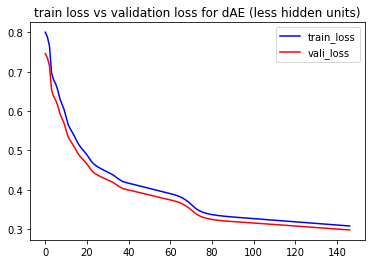

In [134]:
# loss_train_0_100 = copy.deepcopy(loss_train)
# loss_vali_0_100 = copy.deepcopy(loss_vali)
# net_ori = copy.deepcopy(net)
plt.plot(range(len(loss_train)),loss_train,color='b',label = 'train_loss')
plt.plot(range(len(loss_vali)),loss_vali,color='r',label = 'vali_loss')
plt.legend()
plt.title('train loss vs validation loss for dAE (less hidden units)')
plt.show()

test_loss:  0.28953842381647554


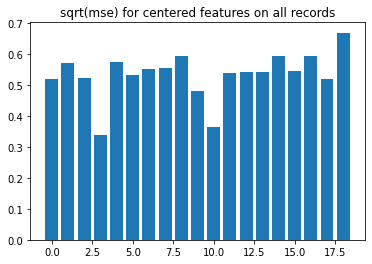

In [135]:
test_out = net.predict(test_norm_rm)
test_mse = loss_f.mse(test_norm,test_out)
print('test_loss: ', test_mse)

mse_cen_all = np.mean((test_out - test_norm)**2,axis = 0)
plt.bar(range(len(mse_cen_all)),np.sqrt(mse_cen_all))
plt.title('sqrt(mse) for centered features on all records')
plt.show()

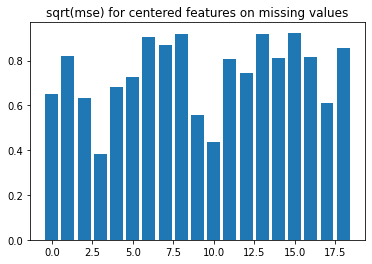

In [136]:
mse_cen_rm = np.sum((test_out - test_norm)**2*test_mask,axis=0)/np.sum(test_mask,axis = 0)
plt.bar(range(len(mse_cen_rm)),np.sqrt(mse_cen_rm))
plt.title('sqrt(mse) for centered features on missing values')
plt.show()

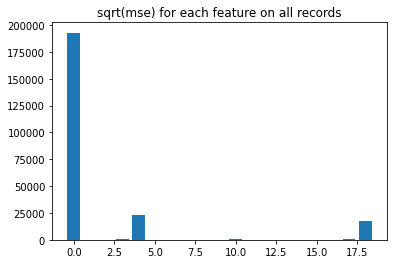

In [137]:
test_pred = denorm(test_out,norm_mean,norm_std)
test_truth = denorm(test_norm,norm_mean,norm_std)
mse_all = np.mean((test_pred - test_truth)**2,axis = 0)

plt.bar(range(len(mse_all)),np.sqrt(mse_all))
plt.title('sqrt(mse) for each feature on all records')
plt.show()

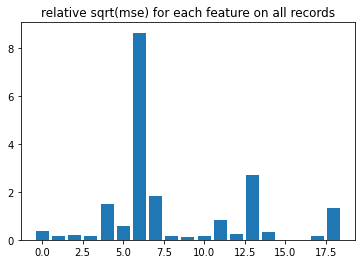

In [138]:
relative_mse_all = ((test_pred - test_truth)/np.mean(test_truth,axis = 0))**2
relative_mse_feature_all = np.mean(relative_mse_all,axis = 0)
plt.bar(range(len(relative_mse_feature_all)),np.sqrt(relative_mse_feature_all))
plt.title('relative sqrt(mse) for each feature on all records')
plt.show()

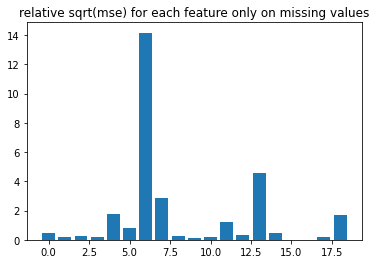

In [139]:
relative_mse_mv = relative_mse_all*test_mask
relative_mse_features_mv = np.sum(relative_mse_mv,axis = 0)/np.sum(test_mask,axis = 0)
plt.bar(range(len(relative_mse_features_mv)),np.sqrt(relative_mse_features_mv))
plt.title('relative sqrt(mse) for each feature only on missing values')
plt.show()

In [113]:
test_pred = pd.DataFrame(test_pred,columns=train_df.columns[0:19])
test_pred.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,822136.608834,3.775244,10.519272,3325.386603,6101.358485,2.152281,0.015332,0.323200,2.202969,7.497126,3293.193182,32.535819,104.241163,1.821291,31.403771,47.633839,-122.035127,3317.568362,9022.052346
1,699088.623247,3.975988,8.147351,2181.691630,13090.257303,-0.032757,-0.011131,0.080028,3.992675,5.775927,1696.042525,486.318661,63.312333,0.840522,23.278642,47.638119,-122.110960,1955.280988,11797.493394
2,910082.413583,3.534854,10.007625,3047.569169,7571.874027,1.820340,0.016539,0.264358,1.987335,7.906082,2981.495087,57.224560,105.408127,1.077331,20.513679,47.571121,-122.143075,3311.850507,10315.599182
3,302123.590552,1.991900,2.737375,999.199065,15732.300199,0.578467,0.006274,0.070536,2.079701,4.245117,921.362501,67.514798,29.734570,7.835041,51.944156,47.545255,-122.356374,1392.775224,12905.961144
4,613502.438048,4.105412,10.241370,2547.084338,14059.328658,2.484362,-0.007232,-0.119823,1.982974,6.656296,2472.217696,78.044104,99.021452,2.004736,40.229169,47.563727,-122.221570,2248.793831,12077.053691


In [126]:
test_truth = pd.DataFrame(test_data,columns=train_df.columns[0:19])
test_truth.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,812000.0,3.0,12.0,3240.0,8338.0,2.0,0.0,0.0,2.0,7.0,3240.0,0.0,101.0,0.0,37.0,47.6321,-122.064,3420.0,8405.0
1,675000.0,4.0,9.0,2040.0,9225.0,0.0,0.0,0.0,4.0,6.0,1610.0,430.0,68.0,0.0,28.0,47.6360,-122.097,1730.0,9225.0
2,830000.0,3.0,11.0,2080.0,10521.0,1.0,0.0,0.0,2.0,7.0,2080.0,0.0,104.0,0.0,22.0,47.6987,-122.228,3730.0,11840.0
3,275000.0,2.0,6.0,930.0,7080.0,0.0,0.0,0.0,2.0,4.0,930.0,0.0,23.0,106.0,44.0,47.5224,-122.360,1100.0,7680.0
4,350000.0,4.0,11.0,2560.0,5606.0,2.0,0.0,0.0,2.0,7.0,2560.0,0.0,104.0,0.0,40.0,47.3274,-122.178,2667.0,7334.0


In [ ]:
# X = np.array([[0,np.nan,1,1,np.nan],
#             [0,1,np.nan,np.nan,1],
#             [0,1,np.nan,1,np.nan],
#             [0,np.nan,1,1,np.nan],
#             [0,np.nan,1,1,np.nan],
#             [0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1]
#             ])

# X_0 = np.array([[0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1],
#             [0,1,1,1,1]
#             ])